# Main file. Here we will train, run and predict files.

### Import packages

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd

### Load data

In [14]:
# Load the data

# Define paths
train_dir = 'data/seg_train'
test_dir = 'data/seg_test'

# Load training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

# Load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode='categorical',
    shuffle=False
)

# Split training into train and validation
val_batches = int(len(train_dataset) * 0.2)
val_dataset = train_dataset.take(val_batches)
train_dataset = train_dataset.skip(val_batches)

# Data Augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Normalization layer
normalization = tf.keras.layers.Rescaling(1./255)

# Apply augmentation only to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.map(lambda x, y: (normalization(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")
print(f"Test batches: {len(test_dataset)}")

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Training batches: 352
Validation batches: 87
Test batches: 94


### Set up models

In [15]:
# Use Transfer Learning with MobileNetV2 (fast and accurate)

# Load pre-trained MobileNetV2 (without top classification layers)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model (we won't train these layers)
base_model.trainable = False

# Build the model
model_cnn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

model_cnn.summary()
print(f"\nTrainable parameters: {sum(p.numel() if hasattr(p, 'numel') else tf.size(p).numpy() for p in model_cnn.trainable_weights):,}")

/var/folders/0m/5c2svgm10xv43m_sr4lhvplc0000gp/T/ipykernel_19172/1065217844.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Trainable parameters: 329,478


In [16]:
# Phase 1: Train with frozen base model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Phase 1: Training with frozen base model...")
history = model_cnn.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Phase 1: Training with frozen base model...
Epoch 1/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.7625 - loss: 0.6482 - val_accuracy: 0.8599 - val_loss: 0.3953
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 94ms/step - accuracy: 0.8047 - loss: 0.5222 - val_accuracy: 0.8614 - val_loss: 0.3856
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 96ms/step - accuracy: 0.8181 - loss: 0.4907 - val_accuracy: 0.8904 - val_loss: 0.3314
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 36s 103ms/step - accuracy: 0.8278 - loss: 0.4647 - val_accuracy: 0.8746 - val_loss: 0.3467
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 37s 105ms/step - accuracy: 0.8310 - loss: 0.4578 - val_accuracy: 0.8883 - val_loss: 0.3145
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step - accuracy: 0.8348 - loss: 0.4493 - val_accuracy: 0.8800 - val_loss: 0.3329
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 35s 98ms/step - accuracy: 0.8355 - loss: 0.4460 - val_accuracy: 0.8757 - val_loss: 0.3436
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 38s

In [17]:
# Phase 2: Fine-tune by unfreezing top layers of base model

base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Trainable layers: {len([l for l in model_cnn.layers[0].layers if l.trainable])}")

# Use a lower learning rate to avoid destroying pre-trained weights
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping_fine = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

print("\nPhase 2: Fine-tuning with unfrozen layers...")
history_fine = model_cnn.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping_fine, lr_scheduler]
)

Trainable layers: 30

Phase 2: Fine-tuning with unfrozen layers...
Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - accuracy: 0.8211 - loss: 0.4978 - val_accuracy: 0.8693 - val_loss: 0.5164 - learning_rate: 1.0000e-04
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.8613 - loss: 0.3859 - val_accuracy: 0.8933 - val_loss: 0.3574 - learning_rate: 1.0000e-04
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.8716 - loss: 0.3482 - val_accuracy: 0.9009 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 46s 131ms/step - accuracy: 0.8873 - loss: 0.3241 - val_accuracy: 0.9109 - val_loss: 0.3107 - learning_rate: 1.0000e-04
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 43s 122ms/step - accuracy: 0.8953 - loss: 0.2939 - val_accuracy: 0.9185 - val_loss: 0.2853 - learning_rate: 1.0000e-04
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 44s 125ms/step - accuracy: 0.8970 - loss: 0.2812 - val_accuracy: 0.9073 - val_loss: 0.2926 - learn

In [18]:
# Note: This cell should be executed AFTER cell 9 (compile and train)
# Evaluate the model on test set
test_loss, test_acc = model_cnn.evaluate(test_dataset)
print(f'\nTest accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')
print(f'Test loss: {test_loss:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9177 - loss: 0.2355

Test accuracy: 0.9177 (91.77%)
Test loss: 0.2355


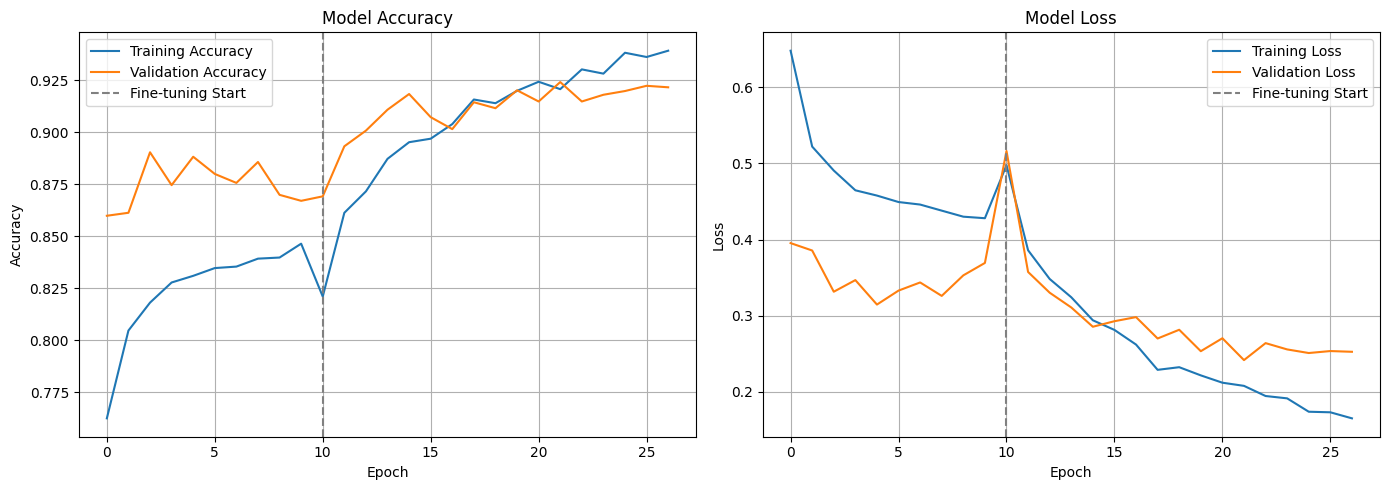

In [19]:
# Plot training history (both phases)
import matplotlib.pyplot as plt

# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Mark where fine-tuning started
fine_tune_start = len(history.history['accuracy'])

# Accuracy plot
ax1.plot(acc, label='Training Accuracy')
ax1.plot(val_acc, label='Validation Accuracy')
ax1.axvline(x=fine_tune_start, color='gray', linestyle='--', label='Fine-tuning Start')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss plot
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.axvline(x=fine_tune_start, color='gray', linestyle='--', label='Fine-tuning Start')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### Predict on unlabeled data

In [20]:
# Load prediction images (no labels)
pred_dir = 'data/seg_pred'

pred_dataset = tf.keras.utils.image_dataset_from_directory(
    pred_dir,
    image_size=(150, 150),
    batch_size=32,
    label_mode=None,  # No labels!
    shuffle=False
)

# Normalize
pred_dataset = pred_dataset.map(lambda x: normalization(x))

# Make predictions
predictions = model_cnn.predict(pred_dataset)

# Get predicted class for each image
predicted_classes = predictions.argmax(axis=1)

# Map to class names
# Get class names from the directory structure
import os
class_names = sorted(os.listdir(train_dir))
# Filter out hidden files and non-directories
class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name)) and not name.startswith('.')]
predicted_labels = [class_names[i] for i in predicted_classes]

# Display some results
print(f"Total images predicted: {len(predicted_labels)}")
print(f"\nPrediction distribution:")
for class_name in class_names:
    count = predicted_labels.count(class_name)
    print(f"  {class_name}: {count} ({count/len(predicted_labels)*100:.1f}%)")

Found 7301 files.
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step
Total images predicted: 7301

Prediction distribution:
  buildings: 1181 (16.2%)
  forest: 1172 (16.1%)
  glacier: 1266 (17.3%)
  mountain: 1293 (17.7%)
  sea: 1181 (16.2%)
  street: 1208 (16.5%)


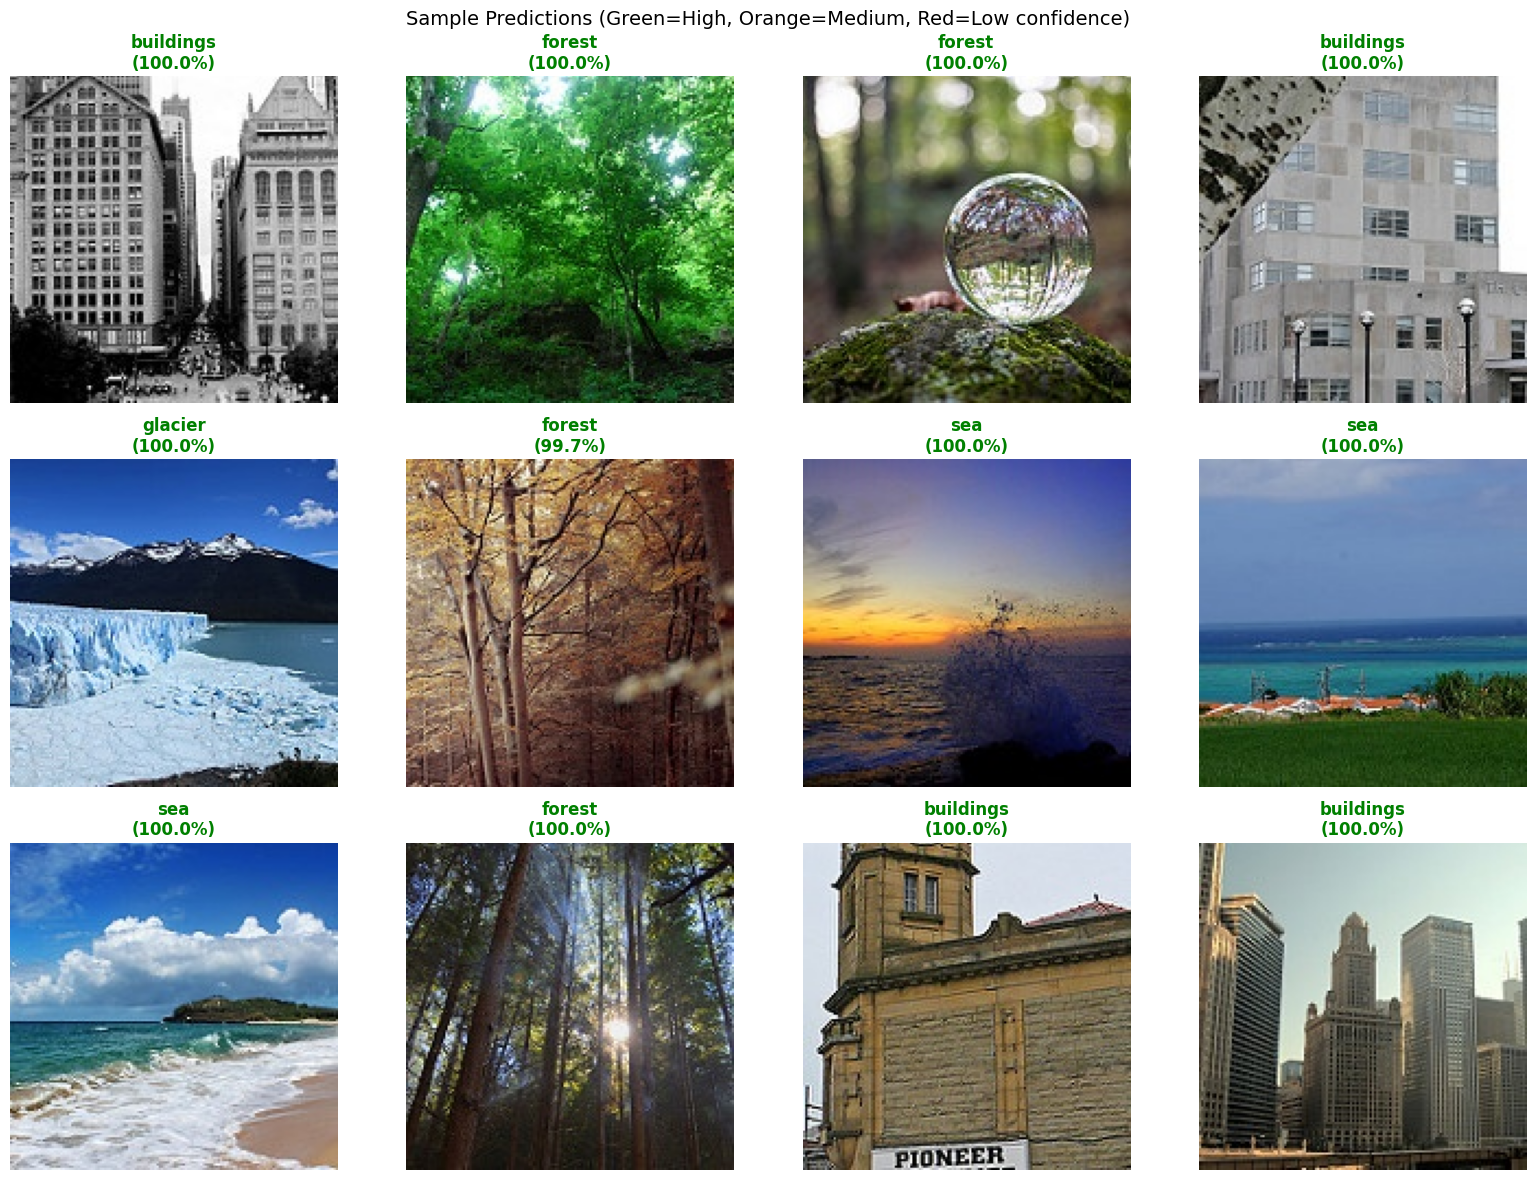


💡 Tip: Look at the images and verify if predictions seem reasonable!
High confidence + correct visual = model is working well


In [21]:
# Visualize sample predictions to manually verify
import matplotlib.pyplot as plt
import os

# Get confidence scores (max probability for each prediction)
confidence_scores = predictions.max(axis=1)

# Get file paths
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.jpg')])

# Show random sample of predictions
np.random.seed(42)
sample_indices = np.random.choice(len(pred_files), size=12, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for idx, ax in zip(sample_indices, axes):
    # Load image
    img_path = os.path.join(pred_dir, pred_files[idx])
    img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
    
    # Get prediction info
    pred_class = predicted_labels[idx]
    conf = confidence_scores[idx]
    
    # Color based on confidence
    color = 'green' if conf >= 0.9 else 'orange' if conf >= 0.7 else 'red'
    
    ax.imshow(img)
    ax.set_title(f"{pred_class}\n({conf:.1%})", fontsize=12, color=color, fontweight='bold')
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=High, Orange=Medium, Red=Low confidence)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 Tip: Look at the images and verify if predictions seem reasonable!")
print("High confidence + correct visual = model is working well")

=== Prediction Confidence Analysis ===

Average confidence: 94.20%
Min confidence: 27.05%
Max confidence: 100.00%

High confidence (≥90%): 6010 (82.3%)
Medium confidence (70-90%): 751 (10.3%)
Low confidence (<70%): 540 (7.4%)


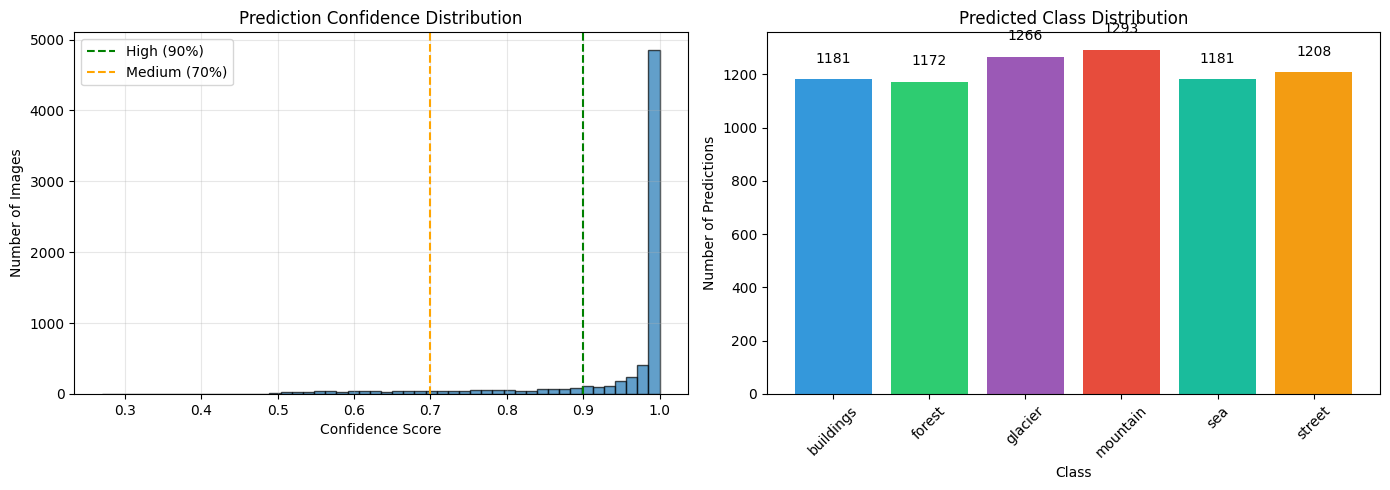

In [22]:
# Evaluate prediction quality (confidence analysis)
import matplotlib.pyplot as plt

# Get confidence scores (max probability for each prediction)
confidence_scores = predictions.max(axis=1)

print("=== Prediction Confidence Analysis ===\n")
print(f"Average confidence: {confidence_scores.mean():.2%}")
print(f"Min confidence: {confidence_scores.min():.2%}")
print(f"Max confidence: {confidence_scores.max():.2%}")

# Count predictions by confidence level
high_conf = (confidence_scores >= 0.9).sum()
medium_conf = ((confidence_scores >= 0.7) & (confidence_scores < 0.9)).sum()
low_conf = (confidence_scores < 0.7).sum()

print(f"\nHigh confidence (≥90%): {high_conf} ({high_conf/len(confidence_scores):.1%})")
print(f"Medium confidence (70-90%): {medium_conf} ({medium_conf/len(confidence_scores):.1%})")
print(f"Low confidence (<70%): {low_conf} ({low_conf/len(confidence_scores):.1%})")

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of confidence scores
axes[0].hist(confidence_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0.9, color='green', linestyle='--', label='High (90%)')
axes[0].axvline(x=0.7, color='orange', linestyle='--', label='Medium (70%)')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar chart of class distribution
class_counts = [predicted_labels.count(c) for c in class_names]
bars = axes[1].bar(class_names, class_counts, color=['#3498db', '#2ecc71', '#9b59b6', '#e74c3c', '#1abc9c', '#f39c12'])
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Predictions')
axes[1].set_title('Predicted Class Distribution')
axes[1].tick_params(axis='x', rotation=45)
for bar, count in zip(bars, class_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()